# Reproducing Biomedical Image Segmentation in the U-Net paper

In this notebook we try to fully reproduce the method presented in the paper ["U-Net: Convolutional Networks for Biomedical Segmentation"](https://arxiv.org/pdf/1505.04597.pdf), particularly, the results presented in table 2 and the pixel error of the U-Net reported in table 1.
The following implementation was carried out without using the pre-existing code, made available by the authors.

## How does U-Net work ?

The U-Net is a convolutional network architecture for fast and precise segmentation of images. It learns segmentation in an end-to-end setting: a raw image is given in input and the output is the segmentation map.

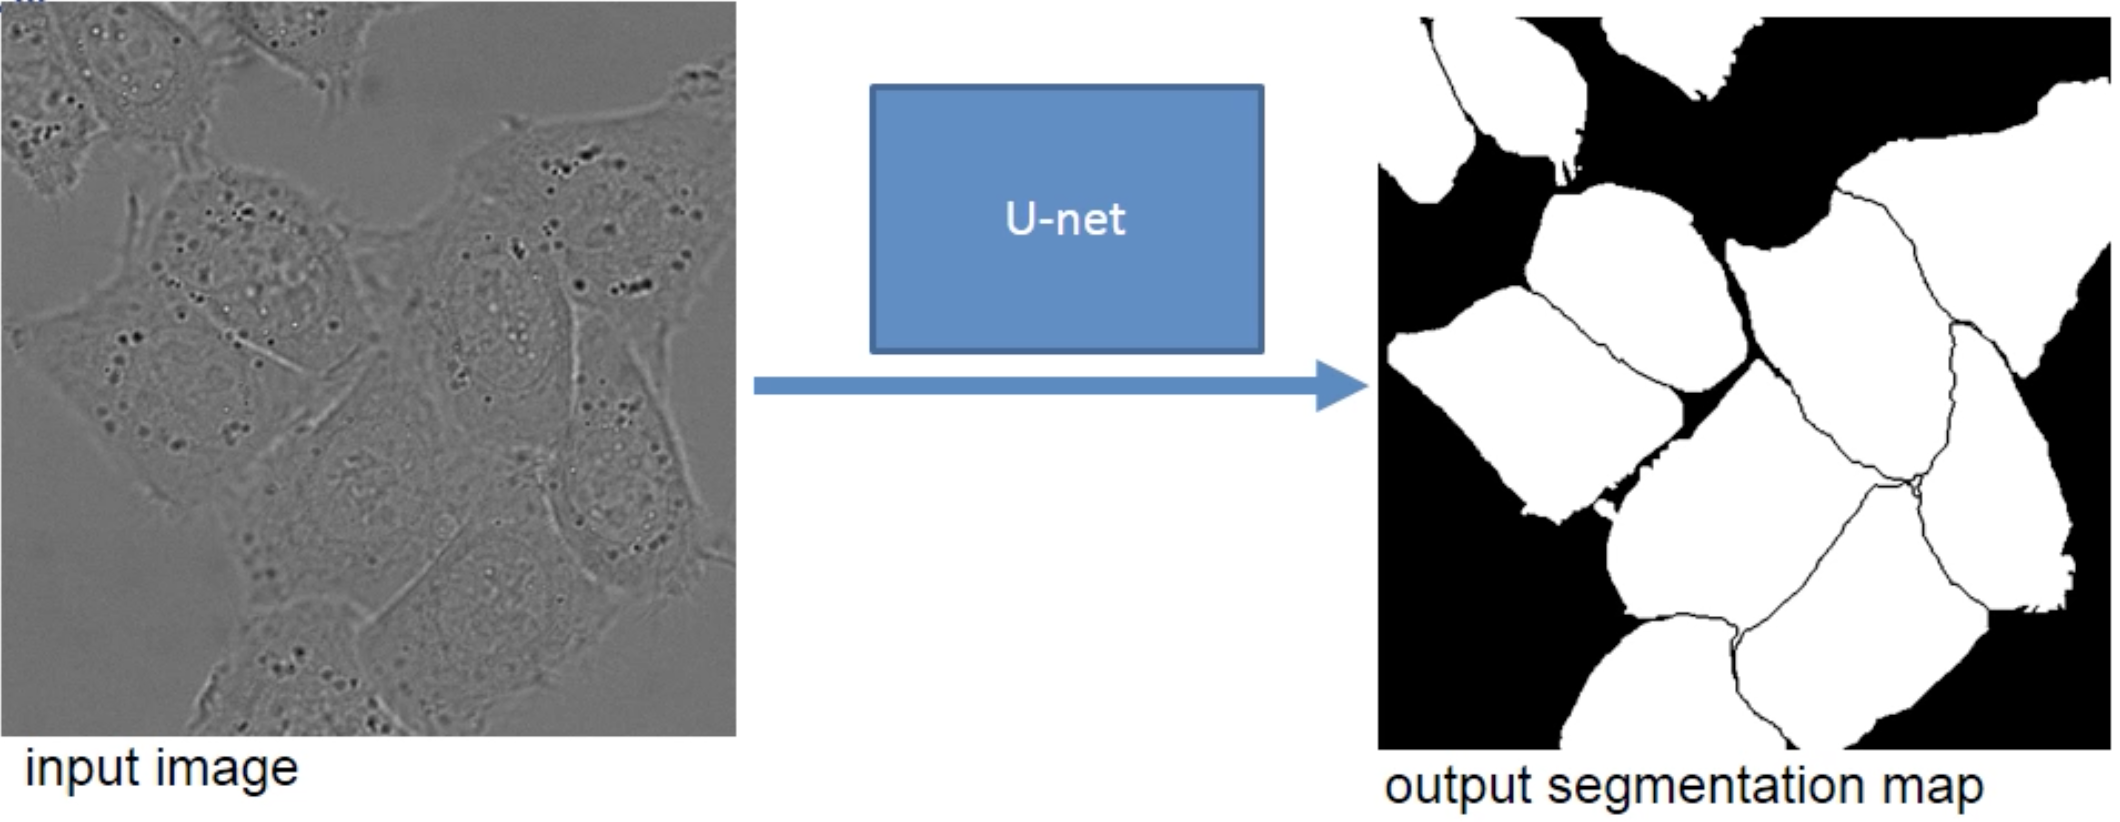

Convolutional network are typically used for classification tasks, so that the obtained output for an input image is a single class label. However, in the considered task of biomedical image segmentation, the desired output has to include localization, that means a class labes must be assigned to each pixel of the image.
To achieve this goal, the paper proposes the U-Net architecture: a contracting path used to capture context in the input image is supplemented with a symmetric expanding path that enables precise localization.

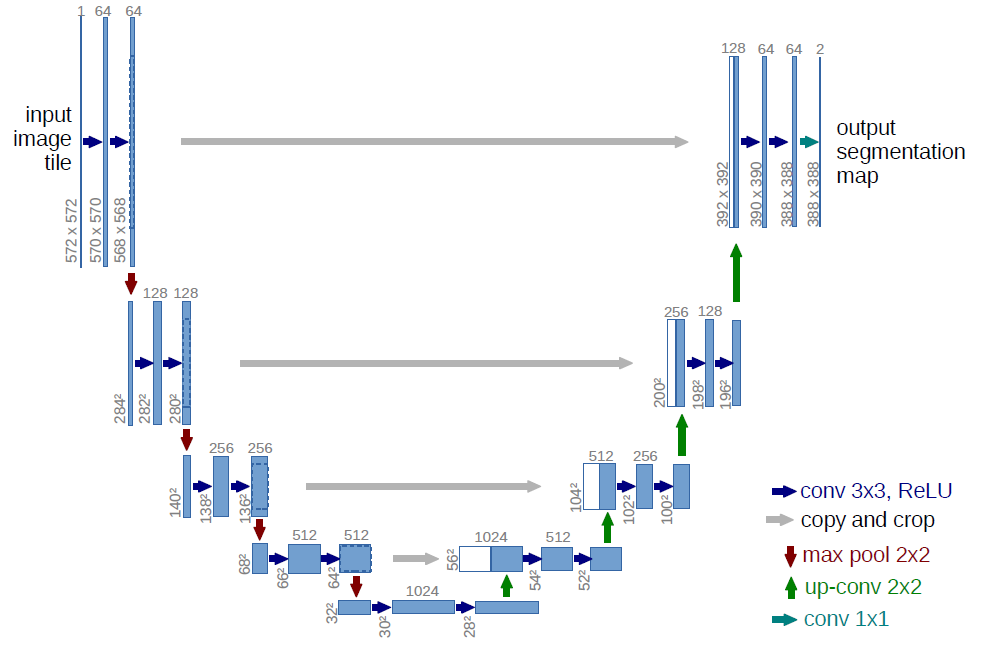

As the previuos image shows, the input image is fed into the network, then the data are propagated into the network according to the displayed path and finally the segmentation map is given as output.
Each blue box corresponds to a multi-channel feature map: the x-y size is reported on the edge, while the number of channel is denoted on top of the box.
The contracting path mimics the classical architecture of a convolutional network with the repeated application of two 3x3 unpadded convolutions each followed by a ReLU and a 2x2 max pooling operation with stride 2.
In the expanding path, the pooling operators are replaced by upsampling operators, 2x2 convolution, that increase the resolution of the output. To achieve localization, high resolution cropped features map from the contracting path are combined with the upsampled output using a concatenation, represented by the grey arrows.
Finally the last layer applies a 1x1 convolution to obtain the output segmentation map with two channels: one for the foreground class and the other for the background one.

Due the unpadded convolution the output is smaller than the input images. As shown by the next figure, the segmentatiom of the yellow area uses iput data of the blue area. This strategy is called "overlap-tile strategy" and thank it allows the segmentation of arbitrarily large images. At the border, data are extrapolated by mirroring.

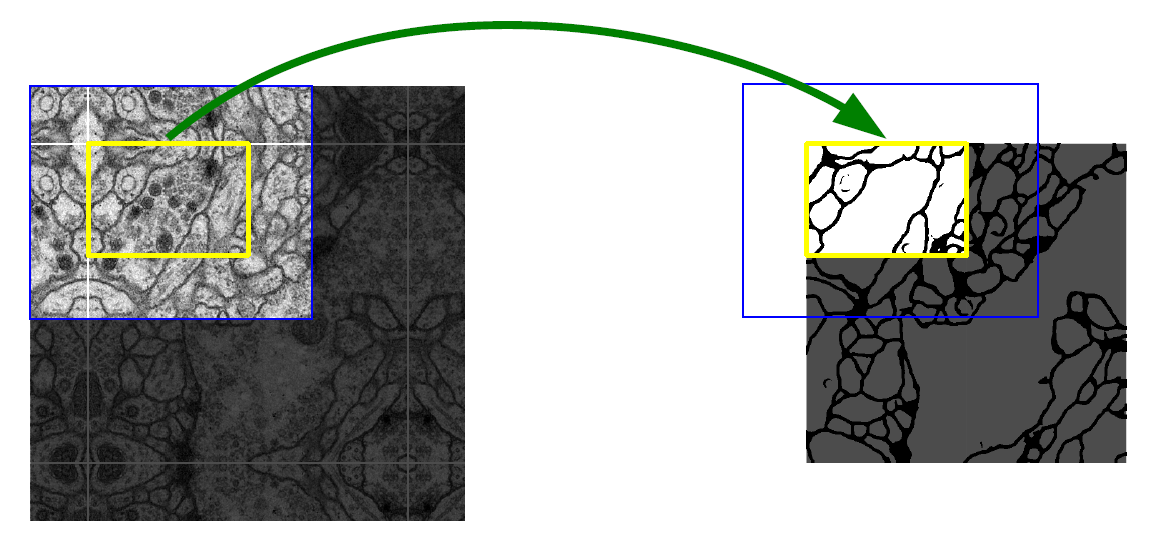

The challenges the paper deals with are the availability of few annotated images, componing the dataset, and the presence of touching objects of the same class that need to be separated by the segmentation algorithm.

The presented training strategy relies indeed on strong use of data augmentation.

To achieve a correct separation of touching objects of the same class, the authors insert an artificial one pixel wide background ridge between touching instances in the ground truth segmentation mask. Moreover, to force the network to learn these artificial ridges, their weight in the loss computation is increased, so that the thinnest ridges have the highest weights.
This is accomplished thanks to a properly defined weight map that will be detailed later in this notebook.

The paper shows that the described network is fast and can be trained end-to-end from a very few images, outperforming the prior best method on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. 

## Experiment Setup

The authors apply the U-Net to three different segmentation tasks.

The first task is the segmentation of neuronal structures in electron microscopic recordings, using the data provided by the EM segmentation challenge, obtaining the best score in terms of warping error (March 2015). The main challenges in this dataset are represented by structure with very low contrast, fuzzy membranes and other cell compartments.

Ranking on the EM segmentation challenge (march 6th, 2015), sorted by warping error:
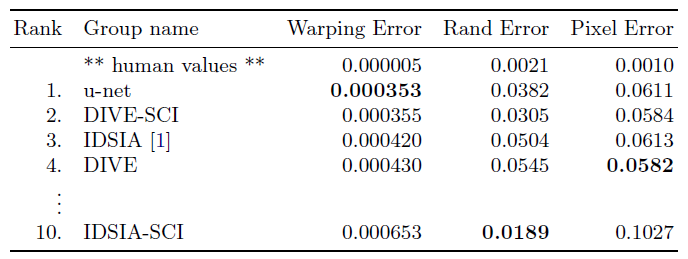

The network is also applied to cell segmentation task in light microscopic images that is part of the ISBI cell tracking challenge2015. 
The first data set "PhC-U373" contains cells recorded by phase contrast microscopy and they show strong shape variation, weak outer borders and strong irrelevant inner borders and the cytoplasm has the same structure like the background. The authors state they obtain a value of 92% IoU (intersection over union) outperforming the second best algorithm with 83%.
The second data set "DIC-HeLa" contains cells on a flat glass recorded by differential interference contrast microscopy: this is one of the most challenging dataset because it contains touching and overlapping cells and partially invisible borders.
Here, according to the paper, the network achieves an average IoU of 77.5% that is significantly better than the score of 46%, obtained with the second best algorithm.

Segmentation results(IoU) on the ISBI cell tracking challenge 2015:
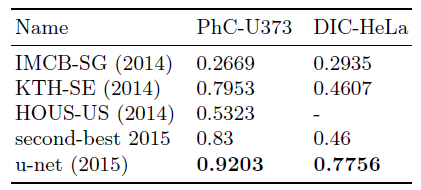

In the remaining part of the notebook, we try to fully reproduce the results presented in table 2 and the pixel error of the U-Net reported in table 1, without using the pre-existing code, made available by the authors.

## Our implementation

To run this notebook, we use a server in Google Cloud platform with a Tesla P100 16GB GPU.


In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.table import QTable, Table, Column

import numpy as np
import cv2 as cv
import os
import shutil
from batchgenerators.utilities.file_and_folder_operations import maybe_mkdir_p

from torchvision.utils import save_image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from data import download_all_data, preprocess_gt, ImageDataset, ImageDataset_test
from network import Unet
from functions import weighted_map, input_size_compute, evaluation_metrics

from time import time

CUR_DIR = os.path.abspath('')

## Dataset

The following part of the notebook download the second and third data set used in the paper and save them in a folder. Then the crop dimension is selected according to the dimensions of the images present is the data set chosen by the user.
Moreover, as mentioned in the previous section, if the data set "DIC-C2DH-HeLa" is picked, one of the main challenge is the presence of objects of the same class overlapping. Semantic segmentation indeed classifies pixels of an images, therefore touching objects of the same class will end up in one joint segment. To face this problem, our routine "preprocess_gt" is called: it highlights object (cell) edges and scales the ground truth from [0,num_objects] to [0, 255], setting background at 0 and all object at 255. It outputs the scaled ground truth with the artificial one pixel wide background ridge between touching instances.
Finally the ground truth is tranformed from grey scale to black and white thanks to a thresholding operation and the pixel wise weight loss is computed and shown.
This last operation is achieved thanks to the "wighted_map" function that highlight the borders between different objects (cells).

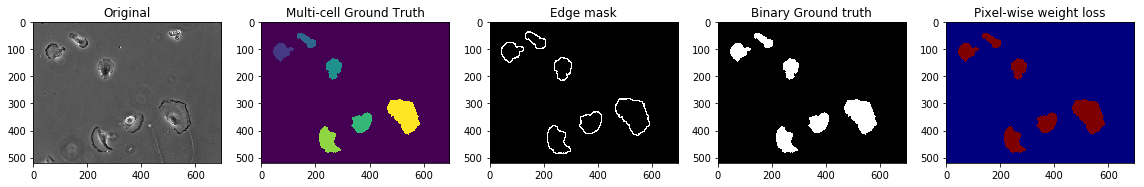

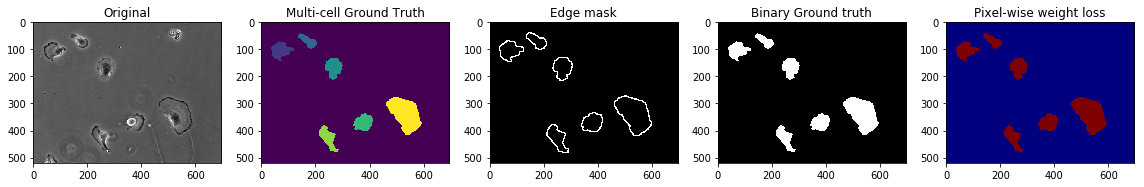

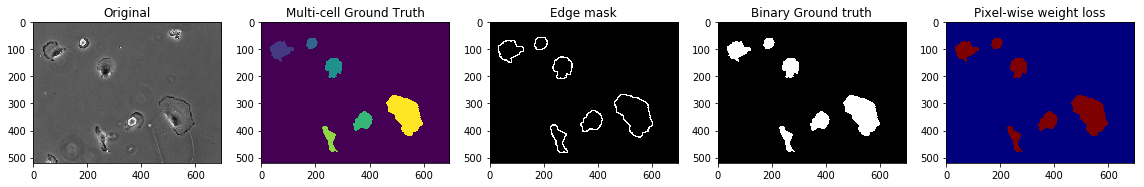

In [2]:
# Download data
download_all_data()

# Specify which dataset to analyse
DATASET = 'PhC-C2DH-U373' # [520, 696]
# DATASET = 'ISBI2012'
# DATASET = 'DIC-C2DH-HeLa'

ISBI2012 = False

if DATASET == 'PhC-C2DH-U373':
    crop = 196
else:
    crop = 388

training_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01")

if DATASET == 'ISBI2012':
    ISBI2012 = True
    target_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01_GT", "SEG")
    target = os.listdir(target_path)    
else:
    target_GT_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01_GT", "SEG")
    target_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01_ST", "SEG")
    target_GT = os.listdir(target_GT_path)
    for image in target_GT:
        os.remove(os.path.join(target_path, image)) 
    target = os.listdir(target_path)    
    for image in target_GT:
        shutil.copyfile(os.path.join(target_GT_path, image), os.path.join(target_path, image))

for i in range(3):
    # load images
    img_training = cv.imread(os.path.join(training_path, f"t{target[i][7:]}"), -1)
    img_gt = cv.imread(os.path.join(target_path, target[i]), -1)
    
    # image morphology, for edge detection (ONLY FOR DIC-C2DH-HeLa, since cells intersect)
    gt, mask_global = preprocess_gt(img_gt)
    if DATASET != "DIC-C2DH-HeLa":
        gt = img_gt
    
    fig = plt.figure(figsize=(16,9))
    plt.subplot(1,5,1)
    plt.imshow(img_training, cmap='gray')
    plt.title("Original")
    plt.subplot(1,5,2)
    plt.imshow(img_gt)
    plt.title('Multi-cell Ground Truth')
    plt.subplot(1,5,3)
    plt.title('Edge mask')
    plt.imshow(mask_global > 0, cmap='gray')  # binary of cell edges
    plt.subplot(1,5,4)

    _, gt_bin = cv.threshold(gt, 0, 255, cv.THRESH_BINARY)
    plt.imshow(torch.from_numpy(gt_bin.astype('uint8')), cmap='gray')
    plt.title('Binary Ground truth')
    
    # Calculating loss for ground truth
    loss_img = weighted_map(torch.from_numpy(gt_bin.reshape((1,1,img_training.shape[0],img_training.shape[1])).astype('float32')) / 255).numpy().reshape((img_training.shape[0],img_training.shape[1]))
    plt.subplot(1,5,5)
    plt.imshow(loss_img, cmap='jet')
    plt.title("Pixel-wise weight loss")
    plt.tight_layout()
    plt.show()

## Data Augmentation

One of the main challenge in biomedical image segmentation is the low number of training data. Data augmentation is indeed required and, particularly, in this paper random elastic deformation is used: this allows the network to learn invariance to such deformation and, moreover, it is important in the considered framework due to the fact deformation is used to be the most common variation in tissue.

In this notebook, the data augmentation is performed by the following piece of code.
An oject data is initialized thanks to the method "init" of our class "ImageDataset" that takes among the inputs some parameters needed to perform the elastic deformation. Due to the fact the authors don't specify thee value for "alpha" in the paper and they didn't reply to our mail where we ask for it, we choose "alpha"=200.
The next operations augment the input mirroring it to generates image such that network's output size is greater or equal than the label size, extrapolating the missing context.
After that we augment the dataset applying first a random rotation of 90° around x axis, or 90° around y axis, or 180° around x axis.
Then we perform an elastic deformation using random displacement vectors on a corse 3 by 3.
According to what state in the paper, the displacement are sampled from a Gaussian distribution with 10 pixels standard deviation (sigma=10). These displacement vectors are used to generate a dense deformation fields using bicubic interpolation.


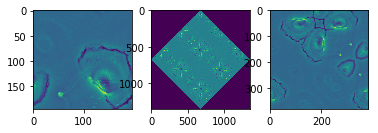

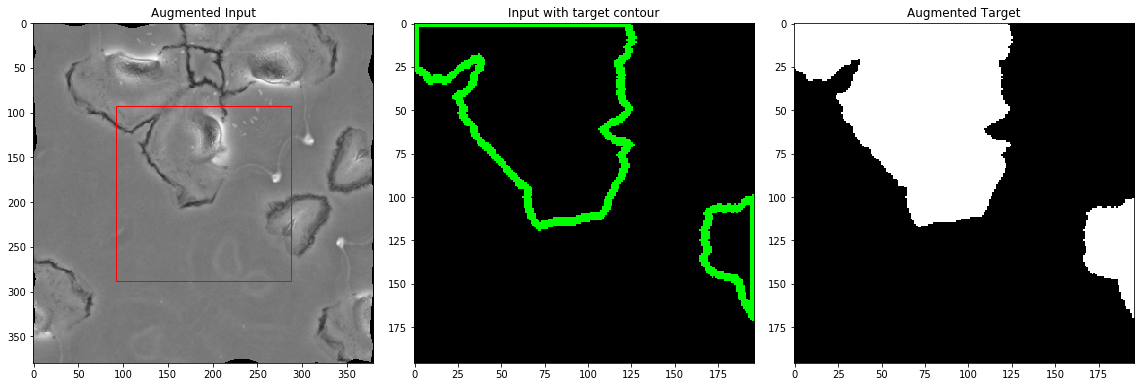

In [3]:
root_dir = os.path.join(CUR_DIR, "data", f"{DATASET}-training")
data = ImageDataset(root_dir, alpha=200, sigma=10, crop=crop, ISBI2012=ISBI2012)   # For training + validation

orig_img = cv.imread(os.path.join(root_dir, '01', os.listdir(os.path.join(root_dir, "01"))[0]), -1)

img, gt = data[0]

original_size, input_size, _ = input_size_compute(gt)
pad = int((input_size - original_size) / 2)

fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

rect = patches.Rectangle((pad,pad),original_size,original_size,linewidth=1,edgecolor='r',facecolor='none')
gt = gt.reshape(gt.shape[1:]).numpy().astype(np.uint8)
contours, hierarchy = cv.findContours(gt, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
image = cv.cvtColor(img.reshape(img.shape[1:])[pad:pad+original_size,pad:pad+original_size].numpy().astype(np.uint8),cv.COLOR_GRAY2RGB)
cv.drawContours(image, contours, -1, (0, 255, 0), 3)

ax0.imshow(img.reshape(img.shape[1:]), cmap='gray')
ax0.add_patch(rect)
ax0.set_title('Augmented Input')
ax1.imshow(image)
ax1.set_title('Input with target contour')
ax2.imshow(gt, cmap='gray')
ax2.set_title('Augmented Target')

fig.tight_layout()
plt.show()

# Training

Based on what is said in the paper, the network is trained using SGD, stochastic gradient descendent, with high momentum (0.99) and a batch size of only a single image, to favor large input tiles. The number of epochs is set to 2 by us.

We perform a cross validation procedure, according to the user defined parameter "val_per" and "tr_per" that define the size of the validation and training set. The creation of these two sets is then carried out thanks to a shuffle procedure applied to the images collected in a vector.

To force the network to learn the artificial one pixel wide background ridge between touching instances we inserted to solve the problem of overlapping objects, the authors of the paper use a weight map that increase the weight of the ridge pixels so that the thinnest ridges get the highest weights.
The complete weight map used is: 
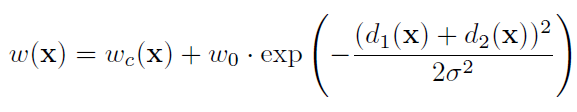

where $w_c$ is the pre-computed weight map for each ground truth segmentation to balance class frequencies. The second term approximate the ridge width at each pixel by the sum of the distance $d_1$ to its nearest instance and the distance $d_2$ to its second nearest istance. According to what is stated in the paper, $\sigma=5$ and $w_0=10$.

The authors state that "the energy function is computed by a pixel-wise soft-max" over the final feature map combined with the cross entropy loss function".
For training, indeed, the final 2-class scores are transformed to probabilities with softmax before they are compared to the ground truth annotations using weighted cross entropy.
We use a binary cross entropy with logits (BCEWithLogitsLoss) as criterion for training using as weight the previous defined weight map. It is important to note that this criterion uses a softmax activation function internally. 

The paper doesn't mention any information about the learning rate: in our implementation we decide to use a variable learning rate that starts from the value 0.001 and then is modified thanks to the "scheduler".

- when learning is modified (patience...)
- stop criteria (number of epoch reached, results outperformed ...)

It is also important to recall that the weights have to be correctly initialized: this is done together with the definition of the U-Net and following the criteria provided by the authors. Accordingly, the weights should be initialized following a gaussian distribution of mean 0 and standard deviation of $\sqrt{(2 / N)}$ with $N$ being the number of incoming nodes of one neuron.

In [4]:
# Parameters:
val_per = 0.2
tr_per  = 1.0 - val_per
batch_size = 1
epochs = 2

In [5]:
root_dir = os.path.join(CUR_DIR, "data", f"{DATASET}-training")
train_dataset = ImageDataset(root_dir, alpha=200, sigma=10, ISBI2012=ISBI2012)   # For training + validation

samp_tr  = int(np.round(tr_per  * len(train_dataset)))
samp_val = int(np.round(val_per * len(train_dataset)))

# We round numbers so that we do not exceed total number of samples
while samp_tr + samp_val > len(train_dataset):
    samp_val += -1

# We generate an order vector to shuffle the samples before each fold for the cross validation  
order = np.arange(len(train_dataset))
np.random.shuffle(order)

# Suffle the training set
train_dataset = [train_dataset[idx] for idx in order]

# Divide between training and validation sets by order (in notebook we only use a few images for speed purposes)
train_set = train_dataset[0:2]
val_set   = train_dataset[2:3]

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=True)

# Shift values in order for next fold of cross validation (a shift of samp_val)
order = np.append(order[samp_val:], order[0:samp_val])
        
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')

else:
    device = torch.device('cpu')
    print('Running on the CPU')

KeyboardInterrupt: 

In [ ]:
# To be called as: training(unet, train_loader, val_loader, epochs, batch_size, device, fold_dir):

train_dir = os.path.join(CUR_DIR, 'nb_train')
maybe_mkdir_p(train_dir)

torch.cuda.empty_cache()
unet = Unet().to(device)

optimizer = optim.SGD(unet.parameters(), lr=0.001, momentum=0.99)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, threshold=1e-2, threshold_mode='rel', eps=1e-7)
my_patience = 0

maybe_mkdir_p(os.path.join(train_dir, 'progress'))
maybe_mkdir_p(os.path.join(train_dir, 'models' ))

loss_best_epoch = 100000.0

for epoch in range(epochs+1):
    
    print(' ')
    print('Epoch:', epoch)

    start = time()
    total_loss = 0
    total_loss_val = 0
    start_eval_train = 0
    start_eval_val = 0

    for batch in train_loader:

        optimizer.zero_grad()

        images, labels = batch
        preds = unet(images.to(device)) # pass batch to the unet

        pad = int((preds.shape[-1] - labels.shape[-1]) / 2)
        preds = preds[:, :, pad:labels.shape[-1]+pad, pad:labels.shape[-1]+pad]

        ll = torch.empty_like(preds)
        ll[:,0,:,:] = 1 - labels[:, 0, :, :]  # background
        ll[:,1,:,:] = labels[:, 0, :, :]  # cell
        ll = ll.to(device)

        weight_maps = weighted_map(labels).to(device)
        criterion = nn.BCEWithLogitsLoss(weight=weight_maps)
        loss = criterion(preds, ll)

        loss.backward() # compute the gradients using backprop
        optimizer.step() # update the weights

        total_loss += loss

        preds = preds.argmax(dim=1)

        for idx in range(preds.shape[0]):
            if start_eval_train == 0 and idx == 0: # First time in epoch we initialize train_eval
                train_eval = evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())
                start_eval_train += 1
            else:
                np.concatenate((train_eval, evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())), axis=1)

    train_eval_epoch = np.mean(train_eval, axis=1)

    with torch.no_grad():
        for batch in val_loader:
            
            images, labels = batch
            preds = unet(images.to(device))

            pad = int((preds.shape[-1] - labels.shape[-1]) / 2)
            preds = preds[:, :, pad:labels.shape[-1]+pad, pad:labels.shape[-1]+pad]

            ll = torch.empty_like(preds)
            ll[:,0,:,:] = 1 - labels[:, 0, :, :] # background
            ll[:,1,:,:] = labels[:, 0, :, :] # cell
            ll = ll.to(device)

            weight_maps = weighted_map(labels).to(device)
            criterion = nn.BCEWithLogitsLoss(weight=weight_maps)
            loss = criterion(preds, ll)

            total_loss_val += loss

            preds = preds.argmax(1)

            for idx in range(preds.shape[0]):
                if start_eval_val == 0 and idx == 0: # First time in epoch we initialize val_eval
                    val_eval = evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())
                    start_eval_val += 1
                else:
                    np.concatenate((val_eval, evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())), axis=1)

    val_eval_epoch = np.mean(val_eval, axis=1)

    scheduler.step(total_loss_val / (len(val_loader) * batch_size)) # update the lr

    for param_group in optimizer.param_groups: l_rate = param_group['lr']

    loss_epoch     = total_loss / (len(train_loader) * batch_size)
    loss_epoch_val = total_loss_val / (len(val_loader) * batch_size)

    if loss_epoch_val < (loss_best_epoch * (1.0 - scheduler.threshold)):
        loss_best_epoch = loss_epoch_val
        print('New best epoch!')
        my_patience = 0
        PATH = os.path.join(train_dir, 'models', 'unet_weight_save_best.pth')
        torch.save(unet.state_dict(), PATH)
        print('Model has been saved:')
        print(PATH)
    else:
        my_patience += 1

    print('Current lr is:             ', l_rate                                      )
    print('Patience is:                {}/{}'.format(my_patience, scheduler.patience))
    print('Mean IoU training:         ', "{:.6f}".format(train_eval_epoch[0])        )
    print('Mean PE training:          ', "{:.6f}".format(train_eval_epoch[1])        )
    print('Mean IoU validation:       ', "{:.6f}".format(val_eval_epoch[0])          )
    print('Mean PE validation:        ', "{:.6f}".format(val_eval_epoch[1])          )
    print('Total training loss:       ', "{:.6f}".format(loss_epoch.item())          )
    print('Total validation loss:     ', "{:.6f}".format(loss_epoch_val.item())      )
    print('Best epoch validation loss:', "{:.6f}".format(loss_best_epoch.item())     )
    print('Epoch duration:            ', "{:.6f}".format(time()-start), 's'          )
    print('                                                                         ')

    # Save progress (evaluation metrics and loss)
    if epoch == 0:
        train_eval_progress_iou = [train_eval_epoch[0]]
        train_eval_progress_pe  = [train_eval_epoch[1]]
        val_eval_progress_iou   = [val_eval_epoch[0]]
        val_eval_progress_pe    = [val_eval_epoch[1]]
        loss_progress           = [loss_epoch.item()]
        loss_progress_val       = [loss_epoch_val.item()]
    elif epoch > 0:
        train_eval_progress_iou = np.concatenate((train_eval_progress_iou, [train_eval_epoch[0]]))
        train_eval_progress_pe  = np.concatenate((train_eval_progress_pe, [train_eval_epoch[1]]) )
        val_eval_progress_iou   = np.concatenate((val_eval_progress_iou, [val_eval_epoch[0]])    )
        val_eval_progress_pe    = np.concatenate((val_eval_progress_pe, [val_eval_epoch[1]])     )
        loss_progress           = np.append(loss_progress, [loss_epoch.item()]                   )
        loss_progress_val       = np.append(loss_progress_val, [loss_epoch_val.item()]           )

    np.savetxt(os.path.join(train_dir, 'train_eval_iou.out'), train_eval_progress_iou)
    np.savetxt(os.path.join(train_dir, 'train_eval_pe.out' ), train_eval_progress_pe )
    np.savetxt(os.path.join(train_dir, 'val_eval_iou.out'  ), val_eval_progress_iou  )
    np.savetxt(os.path.join(train_dir, 'val_eval_pe.out'   ), val_eval_progress_pe   )
    np.savetxt(os.path.join(train_dir, 'loss.out'          ), loss_progress          )
    np.savetxt(os.path.join(train_dir, 'loss_val.out'      ), loss_progress_val      )

    if l_rate < 10 * scheduler.eps and my_patience == scheduler.patience:
        print(f'LR dropped below {10 * scheduler.eps}!')
        print('Stopping training')
        break

    if my_patience == scheduler.patience: my_patience = 0

print('Training is finished as epoch {} has been reached'.format(epochs))

In [ ]:
for i in range(1):
    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    original_size, input_size, _ = input_size_compute(gt)
    pad = int((input_size - original_size) / 2)

    ax0.imshow(images[0, 0, pad:original_size+pad, pad:original_size+pad].detach(), cmap='gray')
    ax1.imshow(preds[0, :, :].detach(), cmap='gray')
    ax2.imshow(labels[0, 0, :, :].detach(), cmap='gray')

    ax0.set_title('Image patch 388*388')
    ax1.set_title('Prediction 388*388')
    ax2.set_title('Label patch 388*388')

## Weight Map

In this part of the code we want to show the effect of the weight map used to force the network to learn the artificial ridges inserted: their weight in the loss computation is increased, so that the thinnest ridges have the highest weights.
As said, this is accomplished thanks to a properly defined weight map and its effect on the loss weight for each pixel is shown in the result of the following lines of code.

In [ ]:
from functions import weighted_map

w = weighted_map(labels[0, :, : ,:])
print(w.shape)

In [ ]:
for i in range(1):
    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(111)
    im = ax0.imshow(w[0, :, :].detach(), cmap='jet')
    ax0.set_title('Weighted map 512*512')
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

## Training progress & overfitting

In [ ]:
progress = f'models/{DATASET}/random_cropping_388/fold0/progress'

In [ ]:
train_loss = np.loadtxt(os.path.join(progress, 'loss.out'))
val_loss   = np.loadtxt(os.path.join(progress, 'loss_val.out'))
train_iou  = np.loadtxt(os.path.join(progress, 'train_eval_iou.out'))
val_iou    = np.loadtxt(os.path.join(progress, 'val_eval_iou.out'))
train_pe   = np.loadtxt(os.path.join(progress, 'train_eval_pe.out'))
val_pe     = np.loadtxt(os.path.join(progress, 'val_eval_pe.out'))

epoch_vec = np.arange(len(train_loss))

In [ ]:
for i in range(1):
    fig = plt.figure(figsize=(16,7))
    ax0 = fig.add_subplot(111)

    ax0.plot(epoch_vec, train_loss, label='Training loss')
    ax0.plot(epoch_vec, val_loss, label='Validation loss')
    ax0.plot(epoch_vec, train_iou, label='Training Eval (Dice)')
    ax0.plot(epoch_vec, val_iou, label='Validation Eval (Dice)')

    ax0.set_title('Training progress')
    ax0.legend()

# Testing

In [ ]:
NETWORK = f'models/{DATASET}/random_cropping_388/fold0/models/unet_weight_save_best.pth'
# NETWORK = 'nb_test/unet_weight_save_5000.pth'
model_path = os.path.join(CUR_DIR, NETWORK)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

# Get test data
test_dataset  = ImageDataset_test(root_dir, ISBI2012=False)   
test_dataset  = [test_dataset[idx] for idx in range(len(test_dataset))]
test_set      = test_dataset[0:1]          
test_loader   = DataLoader(test_set, batch_size=1, shuffle=False)

# Make directory for test outputs (assumes .pth format)
output_dir = model_path[0:len(model_path)-4] + '_test'
maybe_mkdir_p(output_dir)

torch.cuda.empty_cache()
unet = Unet().to(device)
unet.load_state_dict(torch.load(model_path, map_location=device))

In [ ]:
# To be called as: testing(unet, test_loader, batch_size, device, output_dir)

start = time()
start_eval_test = 0
idx = 0

maybe_mkdir_p(os.path.join(output_dir, 'images'))
maybe_mkdir_p(os.path.join(output_dir, 'preds' ))
maybe_mkdir_p(os.path.join(output_dir, 'labels'))

for batch in test_loader:
    
    image, label = batch

    pred = unet(image.to(device))

    pad = int((pred.shape[-1] - label.shape[-1]) / 2)
    pred = pred[:, :, pad:label.shape[-1]+pad, pad:label.shape[-1]+pad].argmax(dim=1)
    pad = int((image.shape[-1] - label.shape[-1]) / 2)
    image = image[0, 0, pad:label.shape[-1]+pad, pad:label.shape[-1]+pad]
    label = label[0, 0, :, :].float()
    pred = pred[0, :, :].float()

    save_image(image, os.path.join(output_dir, 'images', f'image{idx}.tif'))
    save_image(label, os.path.join(output_dir, 'labels', f'label{idx}.tif'))
    save_image(pred,  os.path.join(output_dir, 'preds',  f'pred{idx}.tif' ))

    idx += 1

    if start_eval_test == 0: 
        test_eval = evaluation_metrics(pred.detach(), label.detach())
        start_eval_test += 1
    else:
        np.concatenate((test_eval, evaluation_metrics(pred.detach(), label.detach())), axis=1)

test     = np.mean(test_eval, axis=1)
test_std = np.std(test_eval, axis=1)

test_iou = [test[0], test_std[0]]
test_pe  = [test[1], test_std[1]]
np.savetxt(os.path.join(output_dir, 'test_iou.out'), test_iou)
np.savetxt(os.path.join(output_dir, 'test_pe.out' ), test_pe )

print('Mean IoU testing:', "{:.6f}".format(test[0])          )
print('Mean PE testing :', "{:.6f}".format(test[1])          )
print('Testing took    :', "{:.6f}".format(time()-start), 's')
print('                                                     ')

print('Testing is finished')

In [ ]:
for i in range(1):
    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    pad = int((image.shape[-1] - label.shape[-1]) / 2)

    ax0.imshow(image.detach(), cmap='gray')
    ax1.imshow(pred.detach(),  cmap='gray')
    ax2.imshow(label.detach(), cmap='gray')

    ax0.set_title('Full image 512*512')
    ax1.set_title('Prediction 512*512')
    ax2.set_title('Label 512*512')

In [ ]:
[uval, counts] = torch.unique(label, return_counts=True)

# For the coputation of the w_c tensor:
w_c = torch.empty_like(label)
for pos in range(len(uval)):
    # We normalize all pixel values according to the class frequencies. We also constrain that the cell class is set to 1
    w_c[label == uval[pos]] = counts[1].float() / counts[pos].float() 

# Convert to PyTorch tensor
w_batch = w_c.clone().detach()

print(torch.unique(w_batch))

In [ ]:
from functions import class_balance
w = class_balance(label.reshape([1, 520, 520]))
print(torch.unique(w))

# Results

In [ ]:
DATASET = 'DIC-C2DH-HeLa'
RESULTS1 = f'models/{DATASET}/random_cropping_388/fold0/models/unet_weight_save_best_test'
RESULTS2 = f'models/{DATASET}/random_cropping_388/fold2/models/unet_weight_save_best_test'
RESULTS3 = f'models/{DATASET}/random_cropping_388/fold3/models/unet_weight_save_best_test'

In [ ]:
test_iou1 = np.loadtxt(os.path.join(RESULTS1, 'test_iou.out'))
test_iou2 = np.loadtxt(os.path.join(RESULTS2, 'test_iou.out'))
test_iou3 = np.loadtxt(os.path.join(RESULTS3, 'test_iou.out'))

iou_mean1, iou_std1 = test_iou1
iou_mean2, iou_std2 = test_iou2
iou_mean3, iou_std3 = test_iou3
iou = [iou_mean1, iou_mean2, iou_mean3]

paper_value = 0.7756

In [ ]:
import pandas

data = [round(iou_mean1, 4), round(iou_mean2, 4), round(iou_mean3, 4), round(np.mean(iou), 4), paper_value]
names = ['fold0', 'fold1', 'fold2', 'Average', 'Target']
metric = ['IoU']

pandas.DataFrame(data, names, metric)